## Analysis, Prediction, Recommendation For Churn Rate of a telecom
Raymond Kwok 23 June 2019 (rmwkwok at gmail.com)

# Purpose
1. Given a < 1MB telecom client dataset of 7043 rows and 21 columns, I shall analyze the dataset and produce a prediction model of churn probability, and find out how the probability depends on features and how to reduce it. One interesting point is that some columns' names are encoded and I will define them based on my understanding.

2. This work has 3 notebooks. 
    - This one focuses on exploratory data analysis and feature engineering, that an engineered dataset is produced at the end
    - The dataset will be used in the second notebook for modeling with several approaches, among which I will select the best one based on a few metrics and I will show the feature's importance for the selected model
    - In the last notebook, I will suggest for actions that, based on the model, could effectively reduce the churn rate

## TOC
<a href=#a>A. Modeling</a><br><br>
<a href=#b>B. Comparing models</a><br><br>
<a href=#c>C. Feature Importance</a><br><br>
<a href=#d>D. Summary</a><br><br>

## A. Modeling <a name='a' /></a>

1. Following approaches will be explored with 5-Fold CV Grid-Search

| Method | characteristic | feature importance |
|---|---|---|
|logistic regression|linear in feature space|by coefficients|
|GBDT (lightgbm)|non-linear in feature space|by feature frequency|
|SVM|linear in high dim space|by permutation test|
|NN|non-linear in high dim space|by permutation test|

2. 'F1-score' will be used in Grid-Search as best model criteria
3. The approaches will be compared by F1, accuracy, precision, recall, area-under-ROC scores and logloss
4. Procedure:
    - dataset randomly split into train set and test set
    - <s>upsample train set</s>
    - train a standardized scaler with train set and transform both sets
    - for each approach:
        - 5-Fold CV Grid-search
        - select the model by F1-score
    - tabulate performance of all methods and compare

In [1]:
# packages
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# approaches
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as NN
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGB


from util import bookkeeping, model, model_dt, randColor, permutationtest
%load_ext autoreload
%autoreload 2

In [2]:
# this will collect result of all modelings.
result = {}

In [3]:
# read dataset
dataset = pd.read_csv('./checkpoint01_dataset.csv')

# split to x and y
dataset_x = dataset.drop('is_churn', axis=1)
dataset_y = dataset['is_churn']

# stratify split test set out and keep away from any model training
trn_x, tst_x, trn_y, tst_y = train_test_split(dataset_x, 
                                              dataset_y, 
                                              test_size = 0.2, 
                                              random_state = 3, shuffle = True, 
                                              stratify=dataset_y)

# up-sampling to balance the data
# trn_x, trn_y = oversampling(trn_x, trn_y, smote_ratio=0.7)

# standardize features
scaler = StandardScaler().fit(trn_x)
trn_x = scaler.transform(trn_x)
tst_x = scaler.transform(tst_x)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [4]:
# Logistic regression
fixed  = {'max_iter':10000, 'solver':'lbfgs'}
search = {'C':[.010,.025,.05,.075,.1,.125,.15,.175,.25,.5,.75,1.]}

bookkeeping('lr', trn_x, trn_y, tst_x, tst_y, result,
            model( LR(**fixed), search, trn_x, trn_y )
            )

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.7s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   19.4s finished


In [5]:
# SVC
fixed  = {'kernel':'rbf', 'max_iter':100000, 'probability':True}
search = {'C':[1,5,7.5,10,25,50,100], 'gamma':[1e-4,1e-3,5e-3,1e-2,5e-2,1e-1]}

bookkeeping('svc', trn_x, trn_y, tst_x, tst_y, result,
            model( SVC(**fixed), search, trn_x, trn_y )
            )

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 10.0min
[Parallel(n_jobs=5)]: Done 210 out of 210 | elapsed: 11.1min finished


In [6]:
# NN
fixed  = {'learning_rate_init':0.001, 'learning_rate':'adaptive', 'max_iter':2000,
          'early_stopping':True, 'validation_fraction':0.2, 'n_iter_no_change':5}
search = {'hidden_layer_sizes':[(16,8,4,2),(16,4,2),(16,8),(16,4),(16,8,2),(16,8,4)], 
          #620 parameters for (16,8,4,2) ~10% of data
          'alpha':[0.8,0.9,1,1.1,1.2],
          'solver':['sgd', 'adam']}

bookkeeping('nn', trn_x, trn_y, tst_x, tst_y, result,
            model( NN(**fixed), search, trn_x, trn_y )
            )

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   41.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed:  5.0min finished


In [7]:
# dt - xgboost
fixed  = {'booster':'gbtree', 'learning_rate':0.01, 
          'n_estimators':10000, 'importance_type':'gain'}
search = {'max_depth':[3,5],
           'subsample':[0.85,0.9,0.95],
           'colsample_bytree':[0.85,0.9,0.95],
           'reg_lambda':[9,10,11],}
bookkeeping('XGB', trn_x, trn_y, tst_x, tst_y, result,
            model_dt( XGB(**fixed), search, trn_x, trn_y,
                      early_stopping_rounds = 20 )
            )

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   51.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:  6.1min finished


In [8]:
# dt - lgbm_goss
fixed  = {'boosting':'goss', 'learning_rate':0.01,
          'n_estimators':10000,'importance_type':'gain'}
search = {'max_depth':[3,5],
           'subsample':[0.85,0.9,0.95],
           'colsample_bytree':[0.85,0.9,0.95],
           'reg_lambda':[9,10,11],}
bookkeeping('LGB_goss', trn_x, trn_y, tst_x, tst_y, result,
            model_dt( LGB(**fixed), search, trn_x, trn_y,
                      early_stopping_rounds = 20 )
            )

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.0s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   59.6s
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:  1.4min finished


In [9]:
# dt - lgbm_rf
fixed  = {'boosting':'rf', 'learning_rate':0.01,
          'n_estimators':10000,'importance_type':'gain',
          'bagging_freq':1}
search = {'max_depth':[3,5],
           'subsample':[0.85,0.9,0.95],
           'colsample_bytree':[0.85,0.9,0.95],
           'reg_lambda':[9,10,11],}
bookkeeping('LGB_rf', trn_x, trn_y, tst_x, tst_y, result,
            model_dt( LGB(**fixed), search, trn_x, trn_y,
                      early_stopping_rounds = 20 )
            )

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 130 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:    7.5s finished


In [10]:
# dt - lgbm_gbdt
fixed  = {'boosting':'gbdt', 'learning_rate':0.01,
          'n_estimators':10000,'importance_type':'gain',
          'bagging_freq':1}
search = {'max_depth':[3,5],
           'subsample':[0.85,0.9,0.95],
           'colsample_bytree':[0.85,0.9,0.95],
           'reg_lambda':[9,10,11],}
bookkeeping('LGB_gbdt', trn_x, trn_y, tst_x, tst_y, result,
            model_dt( LGB(**fixed), search, trn_x, trn_y,
                      early_stopping_rounds = 20 )
            )

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 270 out of 270 | elapsed:  1.9min finished


## B. Comparing models <a name='b' /></a>
1. tabulated result
2. graphing the metrics

In [11]:
# display performance of all modelings
display(pd.DataFrame(result))

# Listing the best parameters of each model
print('best parameters for each model')
for k,v in result.items():
    print(k)
    print(v['lb_best'])

,lr,svc,nn,XGB,LGB_goss,LGB_rf,LGB_gbdt
gs,"GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...","GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...","GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...","GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...","GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...","GridSearchCV(cv=StratifiedKFold(n_splits=5, ra...","GridSearchCV(cv=StratifiedKFold(n_splits=5, ra..."
lb_best,{'C': 0.075},"{'C': 25, 'gamma': 0.0001}","{'alpha': 1.1, 'hidden_layer_sizes': (16, 8), ...","{'colsample_bytree': 0.9, 'max_depth': 3, 'reg...","{'colsample_bytree': 0.9, 'max_depth': 3, 'reg...","{'colsample_bytree': 0.95, 'max_depth': 5, 're...","{'colsample_bytree': 0.85, 'max_depth': 3, 're..."
lb_trn_f1,0.609792,0.600989,0.614993,0.62384,0.620052,0.60088,0.623194
lb_tst_acc,0.792466,0.794598,0.78678,0.800995,0.802416,0.78607,0.795309
lb_tst_auroc,0.708559,0.701482,0.704687,0.71522,0.722158,0.705055,0.710495
lb_tst_f1,0.575581,0.565414,0.568966,0.587021,0.597101,0.569385,0.578947
lb_tst_fpr,"[0.0, 0.1122942884801549, 1.0]","[0.0, 0.09970958373668926, 1.0]","[0.0, 0.12003872216844143, 1.0]","[0.0, 0.10164569215876089, 1.0]","[0.0, 0.10648596321393998, 1.0]","[0.0, 0.12197483059051308, 1.0]","[0.0, 0.10842207163601161, 1.0]"
lb_tst_pre,0.630573,0.646048,0.614907,0.654605,0.651899,0.612308,0.63871
lb_tst_recall,0.529412,0.502674,0.529412,0.532086,0.550802,0.532086,0.529412
lb_tst_thres,"[2, 1, 0]","[2, 1, 0]","[2, 1, 0]","[2, 1, 0]","[2, 1, 0]","[2, 1, 0]","[2, 1, 0]"


best parameters for each model
lr
{'C': 0.075}
svc
{'C': 25, 'gamma': 0.0001}
nn
{'alpha': 1.1, 'hidden_layer_sizes': (16, 8), 'solver': 'adam'}
XGB
{'colsample_bytree': 0.9, 'max_depth': 3, 'reg_lambda': 9, 'subsample': 0.85}
LGB_goss
{'colsample_bytree': 0.9, 'max_depth': 3, 'reg_lambda': 11, 'subsample': 0.95}
LGB_rf
{'colsample_bytree': 0.95, 'max_depth': 5, 'reg_lambda': 9, 'subsample': 0.95}
LGB_gbdt
{'colsample_bytree': 0.85, 'max_depth': 3, 'reg_lambda': 10, 'subsample': 0.85}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


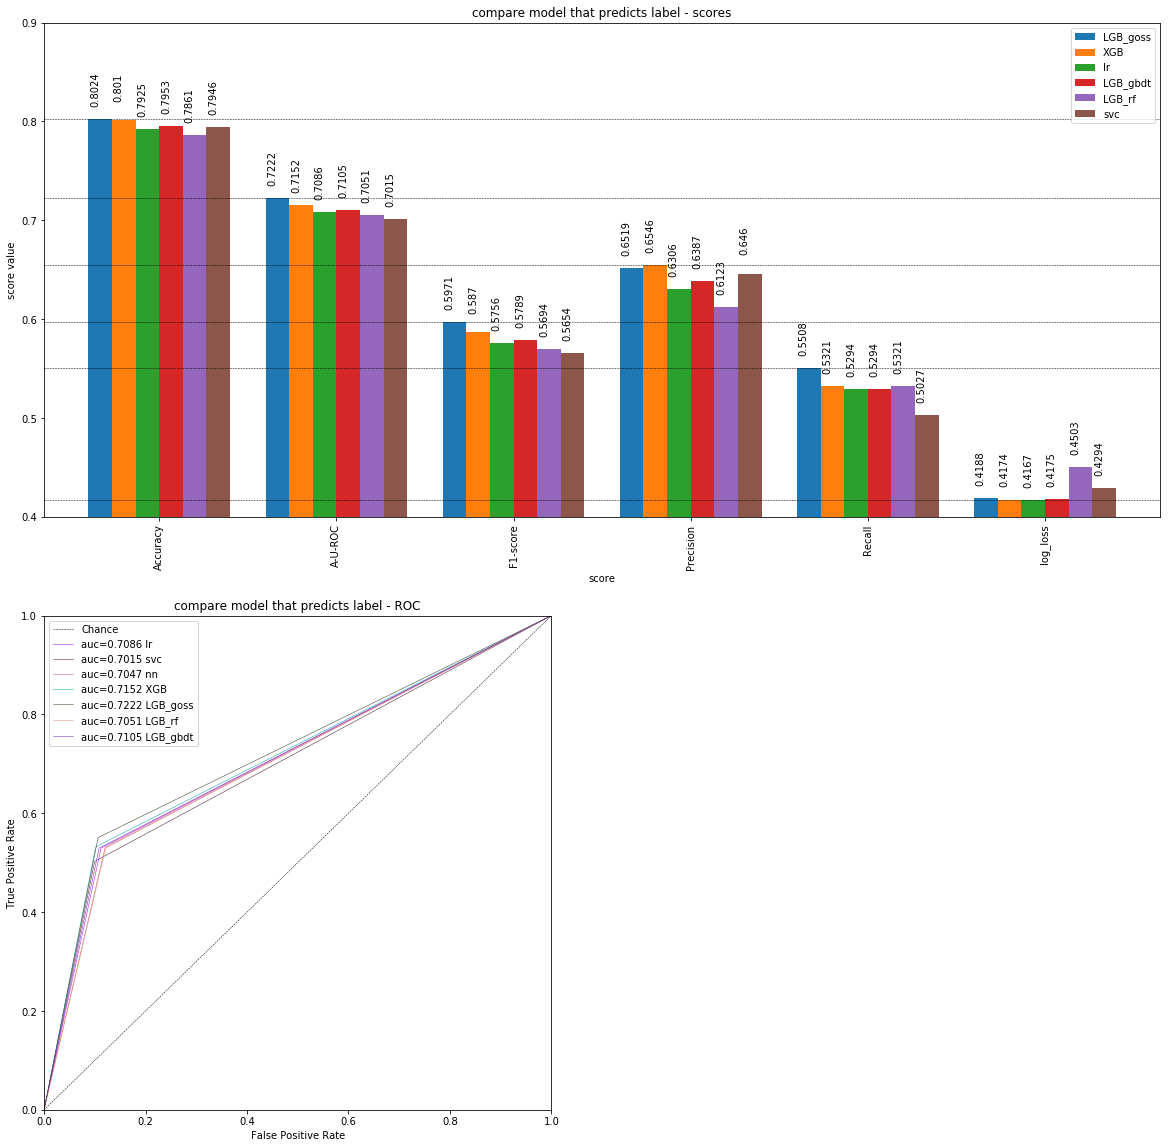

In [12]:
nrow = 2
ncol = 2

fig = plt.figure(figsize=(10*ncol,10*nrow))
axes = [fig.add_subplot(211), fig.add_subplot(223) ]

################
## predicting label - scores and logloss
################
tmp = pd.DataFrame(result)
tmp = tmp[tmp.index.isin(['lb_tst_f1',
                          'lb_tst_acc',
                          'lb_tst_pre',
                          'lb_tst_recall',
                          'lb_tst_auroc',
                          'll_tst'])].astype(float)
tmp = tmp.rename(index={'lb_tst_f1':'F1-score',
                        'lb_tst_acc':'Accuracy',
                        'lb_tst_pre':'Precision',
                        'lb_tst_recall':'Recall',
                        'lb_tst_auroc':'A-U-ROC',
                        'll_tst':'log_loss'})

# order columns (model) by the number of score it achieved the best
colOrder = []
while len(colOrder) < len(tmp):
    colOrder += tmp.drop(colOrder,axis=1)\
                   .apply(lambda r: r.argmin() if r.name=='log_loss' else\
                                    r.argmax(), axis=1).value_counts().index.tolist()
tmp = tmp[colOrder]

# plot
ax = axes[0]
tmp.plot(kind='bar', ax=ax, width=0.8)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.4}'.format(height), (x+0.01, y + height + 0.04), rotation=90)
    
# for each score type, plot the max level
for c in tmp.index:
    if c == 'log_loss':
        v = tmp.loc[c].min()
    else:
        v = tmp.loc[c].max()
    ax.axhline(v, ls='--', lw=0.5, c='black')
    
ax.set_title('compare model that predicts label - scores')
ax.set_xlabel('score')
ax.set_ylabel('score value')
ax.set_ylim(0.4,0.9)
ax.legend()

################
## predicting label - area under ROC
################

ax = axes[1]
ax.plot([0, 1], [0, 1], ls='--', lw=.5, c='black', label='Chance')
cs = randColor(len(result))

for c, (k,v) in zip(cs, result.items()):
    fpr = v['lb_tst_fpr']
    tpr = v['lb_tst_tpr']
    auc = v['lb_tst_auroc']
    thres = v['lb_tst_thres']
    ax.plot(fpr, tpr, lw=.5, c=c, label='auc=%.4f %s'%(auc,k))

ax.set_title('compare model that predicts label - ROC')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()

plt.show()

## C. Feature Importance <a name='c' /></a>

1. logistic regression: taking absolute value of features' coefficients, normalized by the total
2. decision trees: by gain of features, normalized by the total
3. everyone: by permutation test, normalized by the total

In [13]:
# lr
imp = pd.DataFrame({'lr_lb_coef':np.abs(result['lr']['gs'].best_estimator_.coef_[0]) })

# decision trees
for k in ['XGB', 'LGB_goss', 'LGB_rf', 'LGB_gbdt']:
    if k not in result:
        continue
    tmp = pd.DataFrame({'%s_lb_gain'%k:result[k]['gs'].best_estimator_.feature_importances_ })
    imp = imp.join(tmp)

# apply permutation test to all models
for k,v in result.items():
    print(k)
    tmp = pd.DataFrame({'%s_lb_perm'%k:permutationtest(v['gs'].best_estimator_, 'f1', trn_x, trn_y),
                        '%s_ll_perm'%k:permutationtest(v['gs'].best_estimator_, 'll', trn_x, trn_y) })
    imp = imp.join(tmp)

# name index properly and normalize each column by itself
imp.index = dataset_x.columns
imp = imp/imp.sum(axis=0)

lr
svc
nn
XGB
LGB_goss
LGB_rf
LGB_gbdt


Next, I will get:
1. weighted importance
    - for each feature, I get the weighted sum of feature importance among all models, weighted by the model's accuracy
2. best model's importance
    - I simply pick the model that has more top scores, amd use its importance value

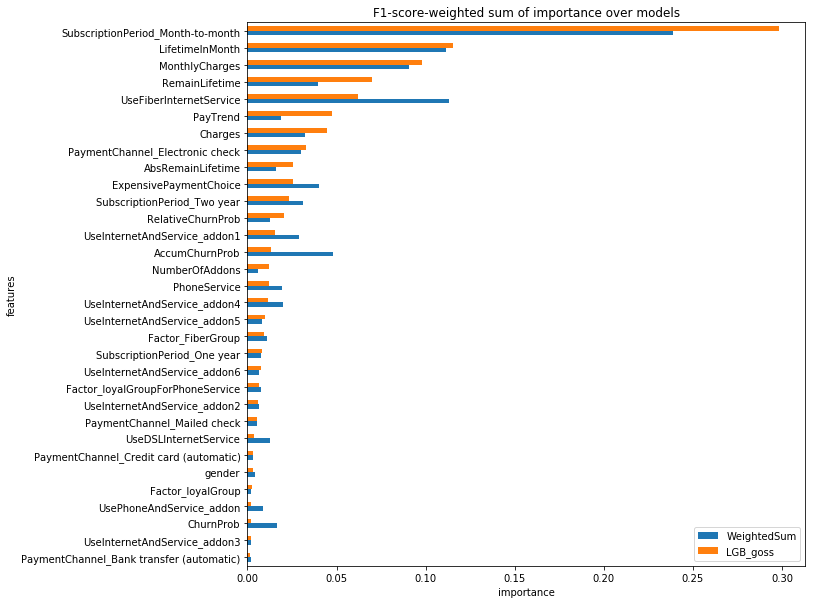

In [14]:
# Helper function
def score_mapper(f1_scores, c):
    for k, v in f1_scores.items():
        if k in c:
            return v

##################
## weighted importance
##################

imp_copy  = imp[imp.columns[['lb' in c for c in imp]]]
f1_scores = pd.DataFrame(result).loc['lb_tst_f1']
f1_scores = pd.Series({c:score_mapper(f1_scores, c) for c in imp_copy.columns})
f1_scores = f1_scores/sum(f1_scores)

weighted_importance = (f1_scores*imp_copy).sum(axis=1).sort_values(ascending=True)

##################
## best model importance
##################
bestmodel  = colOrder[0]
impcolname = [c for c in imp.columns if bestmodel in c][0]
bestmodel_importance  = imp[impcolname].sort_values(ascending=True)

##################
## combine the two
##################

final_importance = pd.DataFrame({'WeightedSum': weighted_importance, bestmodel: bestmodel_importance})\
                     .sort_values(bestmodel,ascending=True)


fig, ax = plt.subplots(1,1,figsize=(10,10))
final_importance.plot(kind='barh', ax=ax)
ax.set_title('F1-score-weighted sum of importance over models')
ax.set_xlabel('importance')
ax.set_ylabel('features')
plt.show()

In [15]:
# save model result and feature importance
pickle.dump(scaler, 
            open('./checkpoint02_model_scaler.pkl','wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(result, 
            open('./checkpoint02_model_result_dict.pkl','wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(bestmodel, 
            open('./checkpoint02_model_best_model_str.pkl','wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(imp, 
            open('./checkpoint02_model_feature_importance_df.pkl','wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

pickle.dump(bestmodel_importance, 
            open('./checkpoint02_model_best_model_feature_importance_series.pkl','wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

## D. Summary <a name='d' /></a>
1. 7 models are compared via 6 metrics, and the best model is chosen.
2. Feature importance of the best model and weighted sum over all models are shown.